13568290/13568290 [==============================] - 0s 0us/step


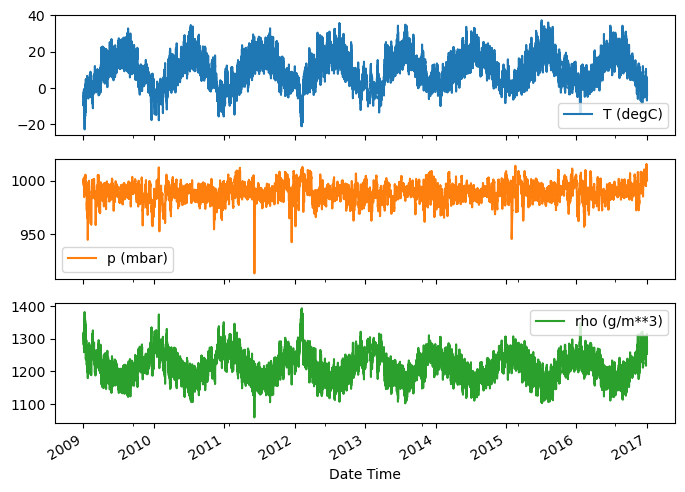

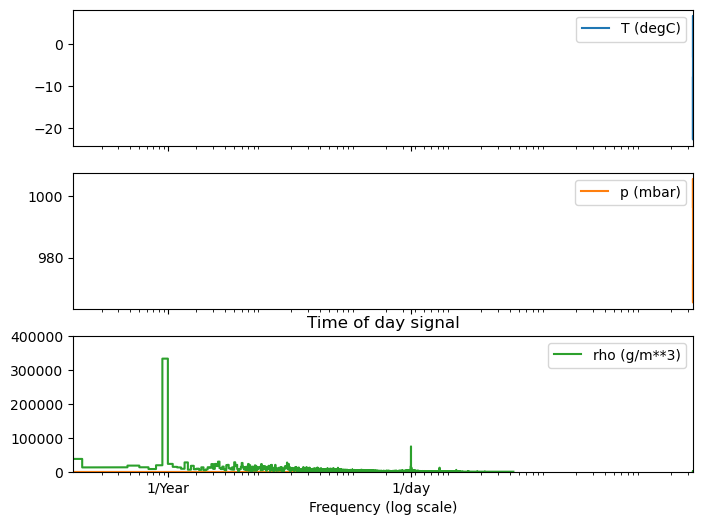

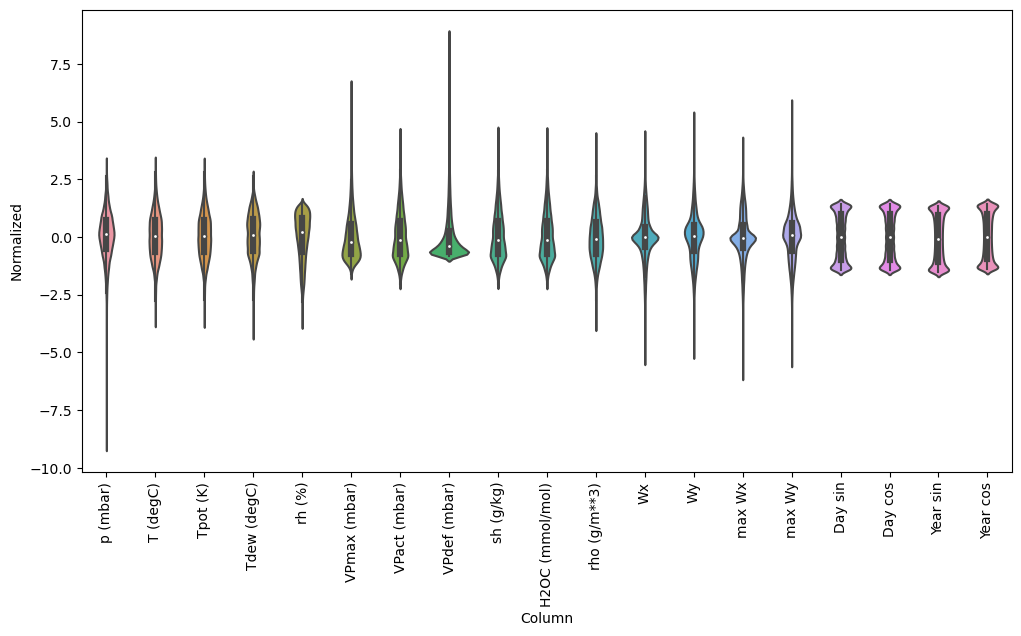

In [2]:
# Time series forecasting

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams["figure.figsize"] = (8, 6)
mpl.rcParams["axes.grid"] = False

# Load and read the weather ts dataset of Max Planck Institute

zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True,
)
csv_path, _ = os.path.splitext(zip_path)


df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop("Date Time"), format="%d.%m.%Y %H:%M:%S")


# Visualize data

plot_cols = ["T (degC)", "p (mbar)", "rho (g/m**3)"]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

# Wind velocity data cleanup
wv = df["wv (m/s)"]
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df["max. wv (m/s)"]
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0


# Feature Engineering - convert the wind direction and velocity columns to a wind vector

wv = df.pop("wv (m/s)")
max_wv = df.pop("max. wv (m/s)")

# Convert to radians.
wd_rad = df.pop("wd (deg)") * np.pi / 180

# Calculate the wind x and y components.
df["Wx"] = wv * np.cos(wd_rad)
df["Wy"] = wv * np.sin(wd_rad)

# Calculate the max wind x and y components.
df["max Wx"] = max_wv * np.cos(wd_rad)
df["max Wy"] = max_wv * np.sin(wd_rad)

# convert Date time column into seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# "Time of day" and "Time of year"  periodic signals
day = 24 * 60 * 60
year = (365.2425) * day

df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
# Plot

plt.plot(np.array(df["Day sin"])[:25])
plt.plot(np.array(df["Day cos"])[:25])
plt.xlabel("Time [h]")
plt.title("Time of day signal")


# determine which frequencies are important

fft = tf.signal.rfft(df["T (degC)"])  # --> using Fast Fourier Transform
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["T (degC)"])
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / (hours_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
_ = plt.xlabel("Frequency (log scale)")


# data splitting

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

num_features = df.shape[1]


# feature scaling

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# baseline modelling
class Baseline(tf.keras.Model):
 def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

 def call(self, inputs):
    if self.label_index is None:
        return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

    
class ResidualWrapper(tf.keras.Model):
 def __init__(self, model):
        super().__init__()
        self.model = model

 def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta
    
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
                       

                       
class FeedBack(tf.keras.Model):
 def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
                       
class RepeatBaseline(tf.keras.Model):
 def call(self, inputs):
        return inputs

437/437 [==============================] - 4s 9ms/step - loss: 0.2235 - mean_absolute_error: 0.2998
Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2984
Dense   : 0.2794
Conv    : 0.2750
LSTM    : 0.2758
AR LSTM : 0.2899


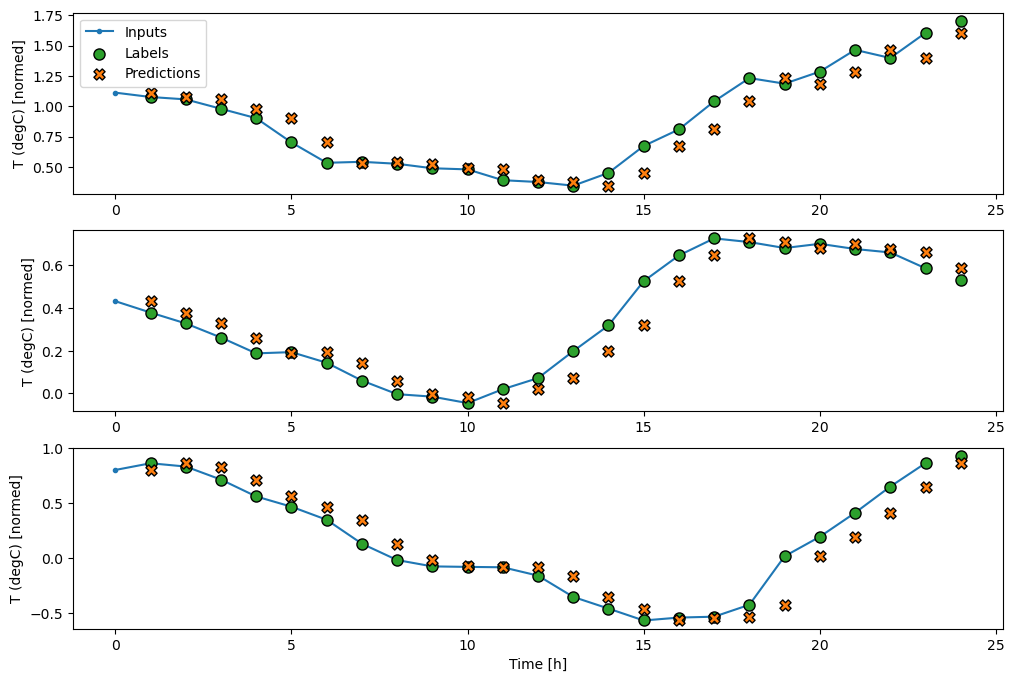

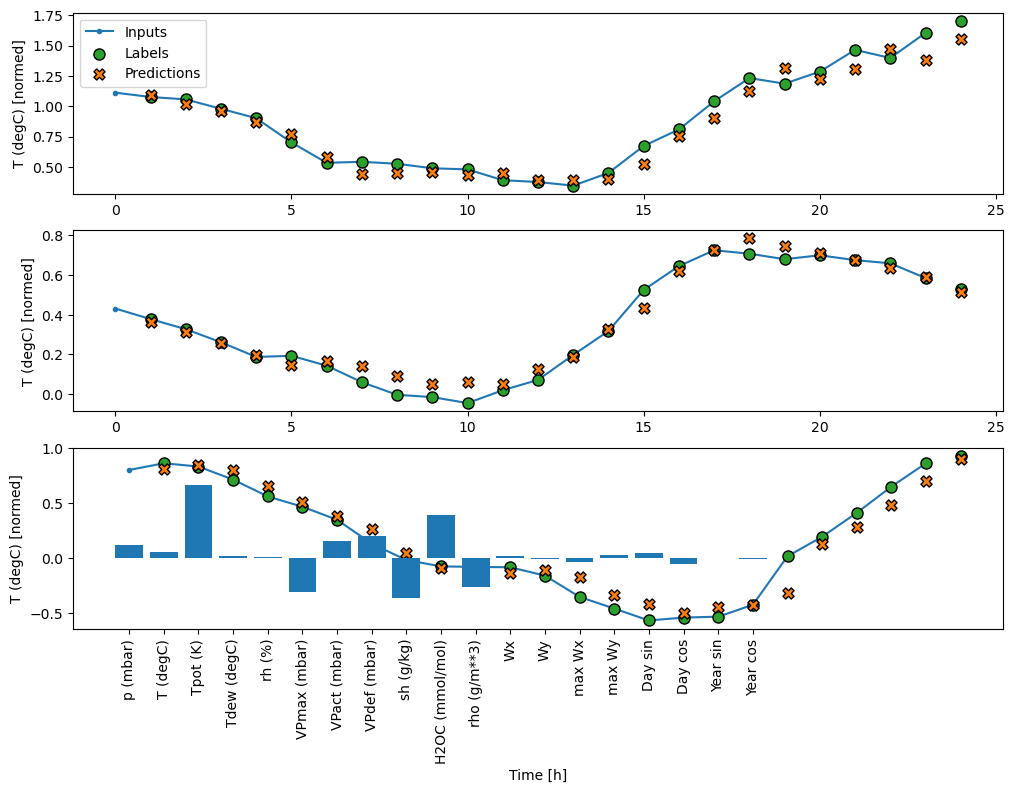

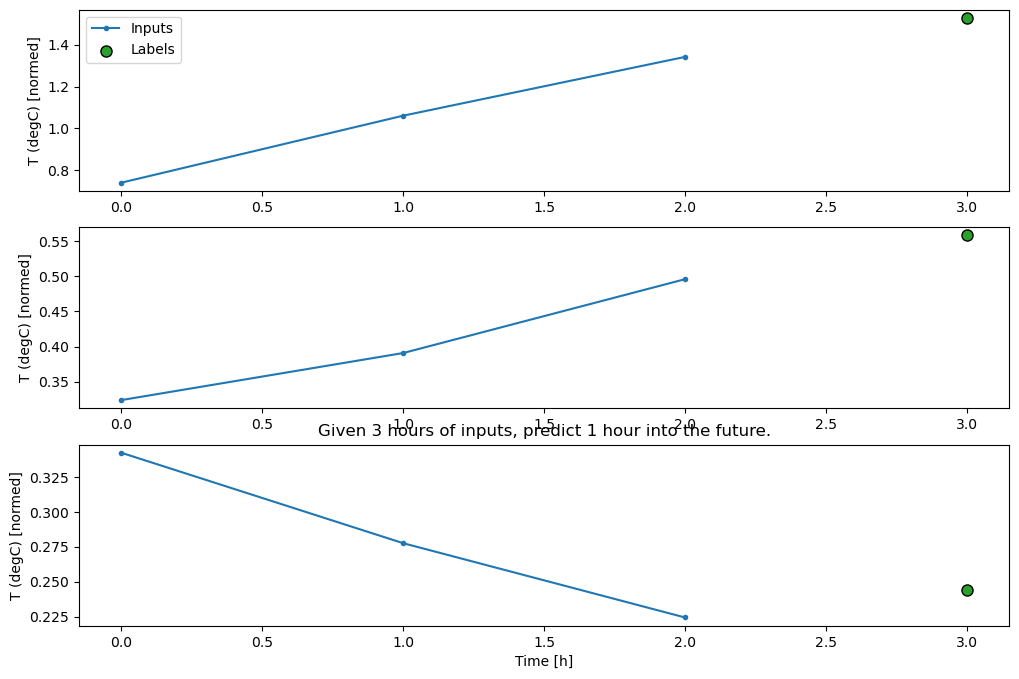

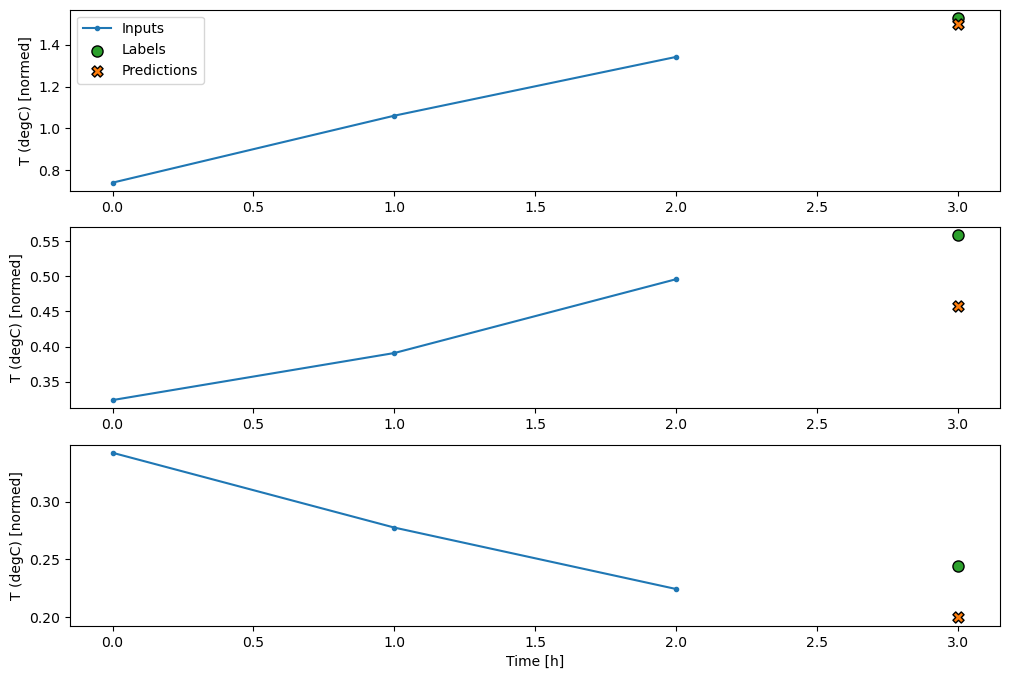

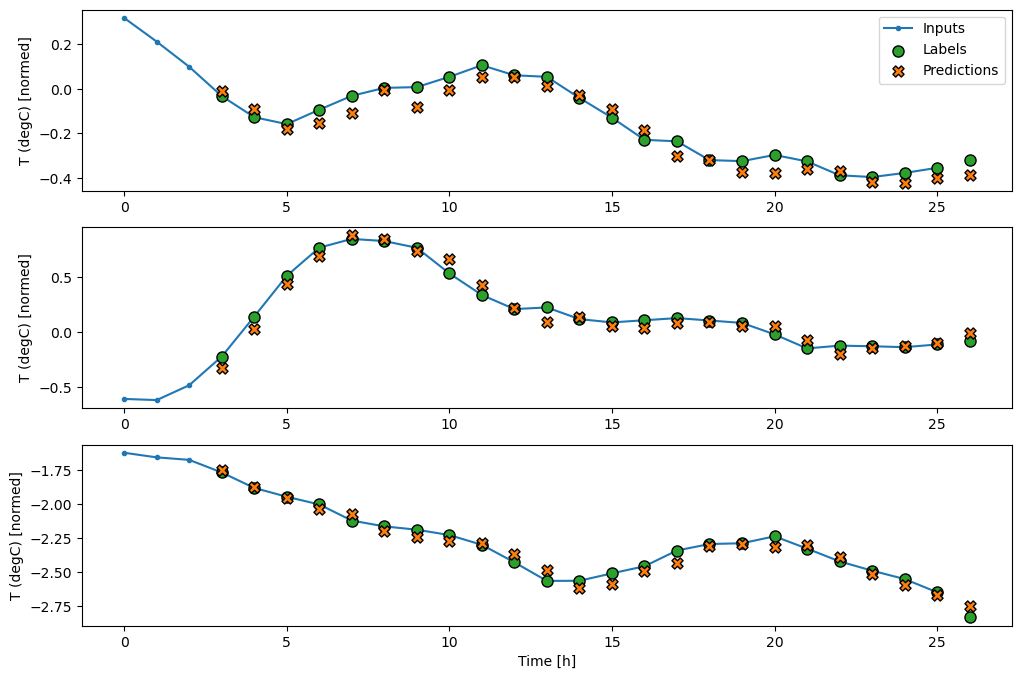

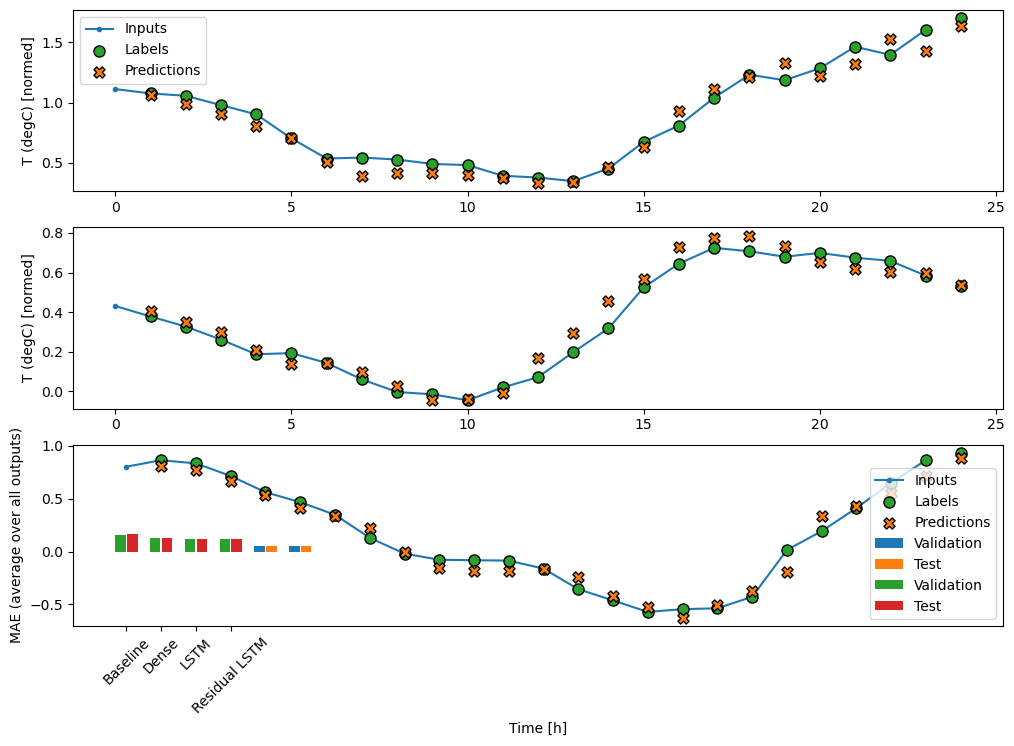

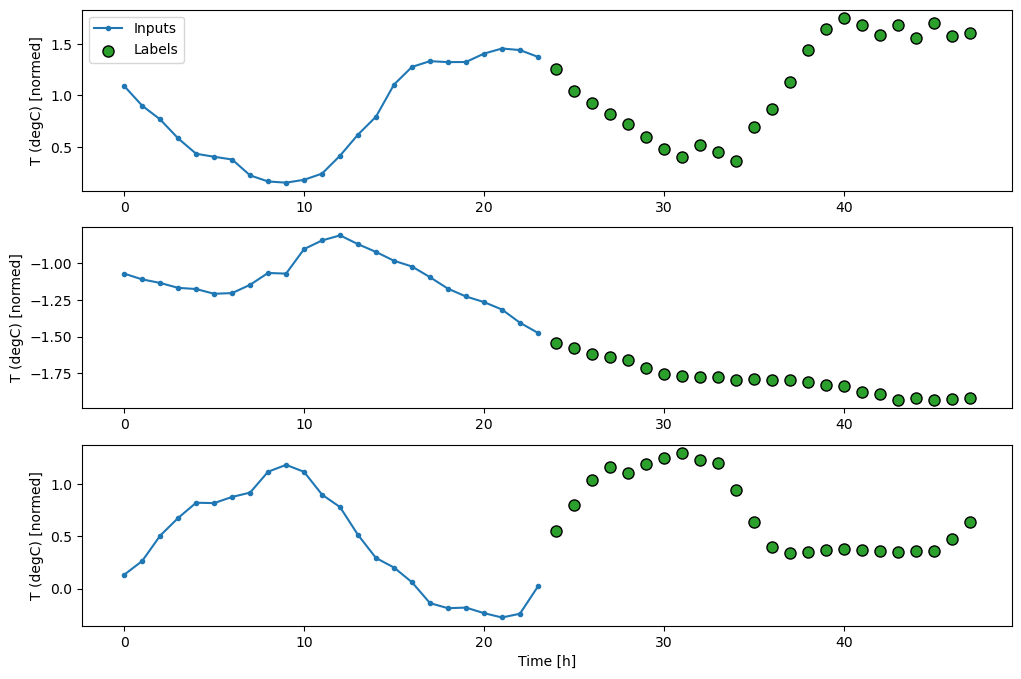

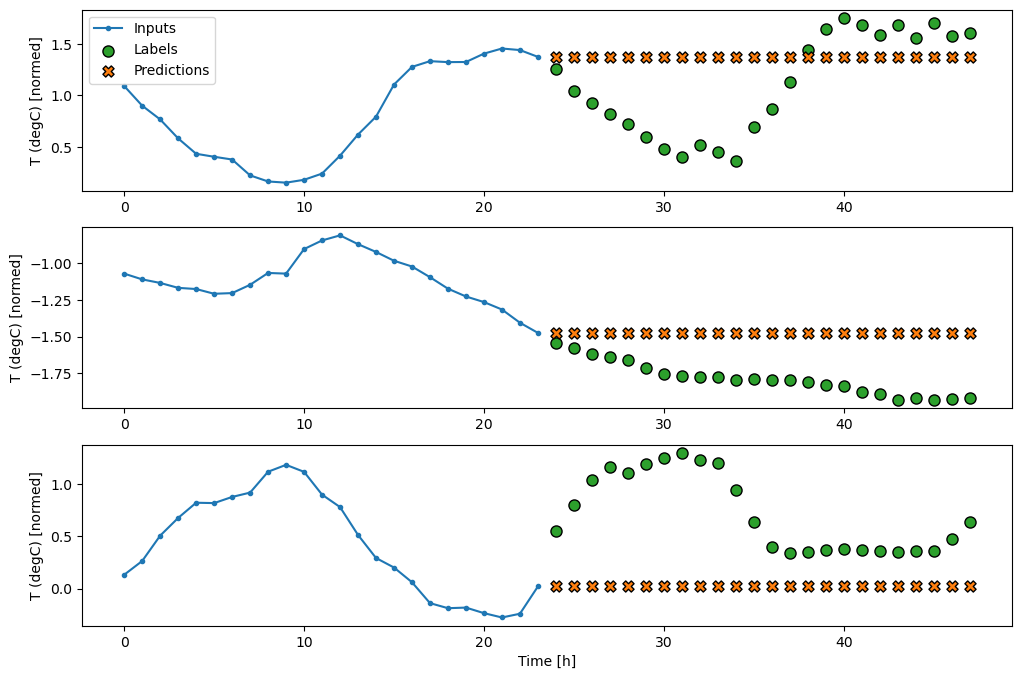

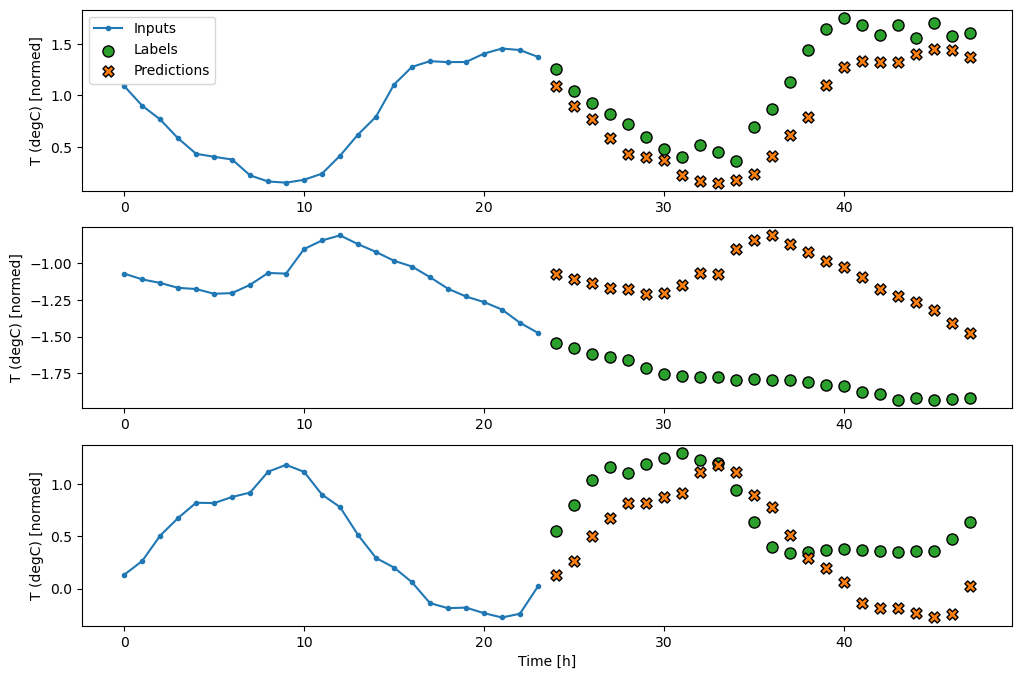

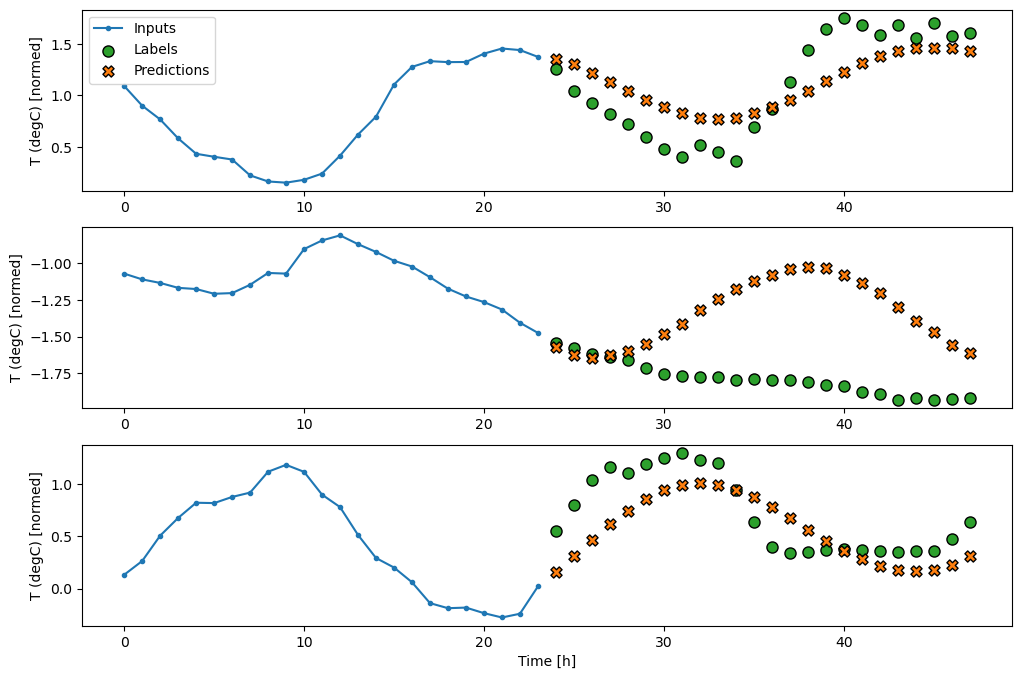

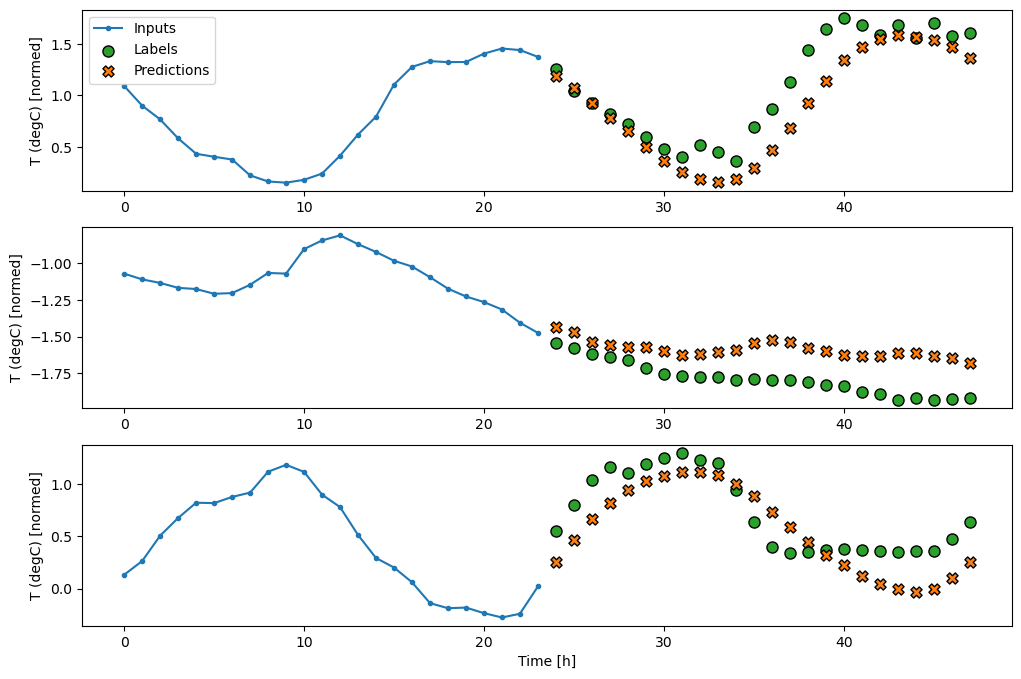

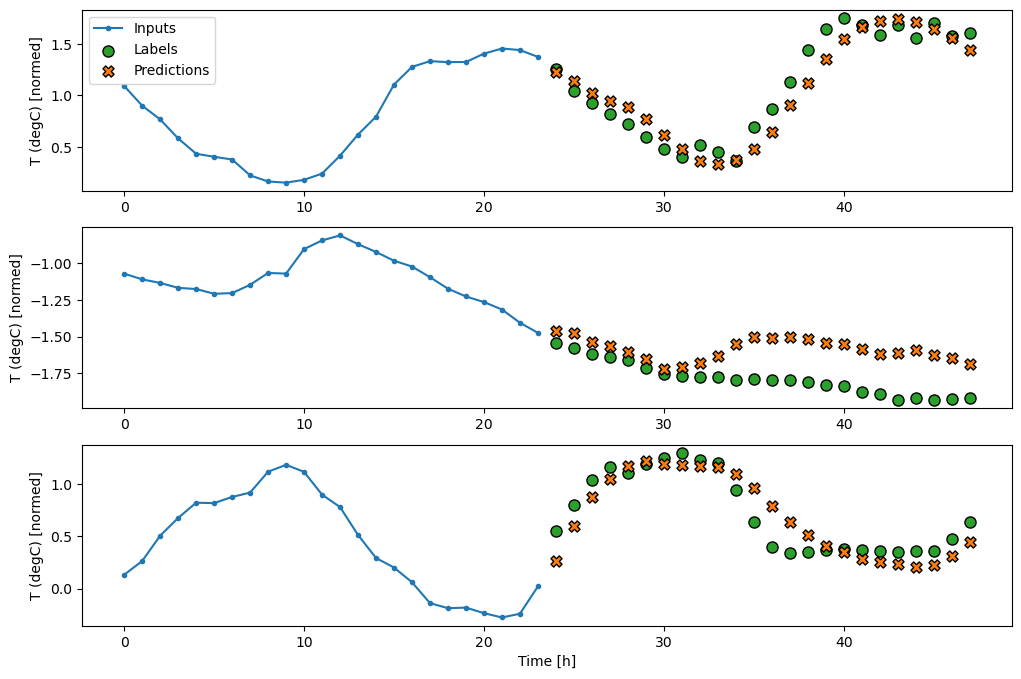

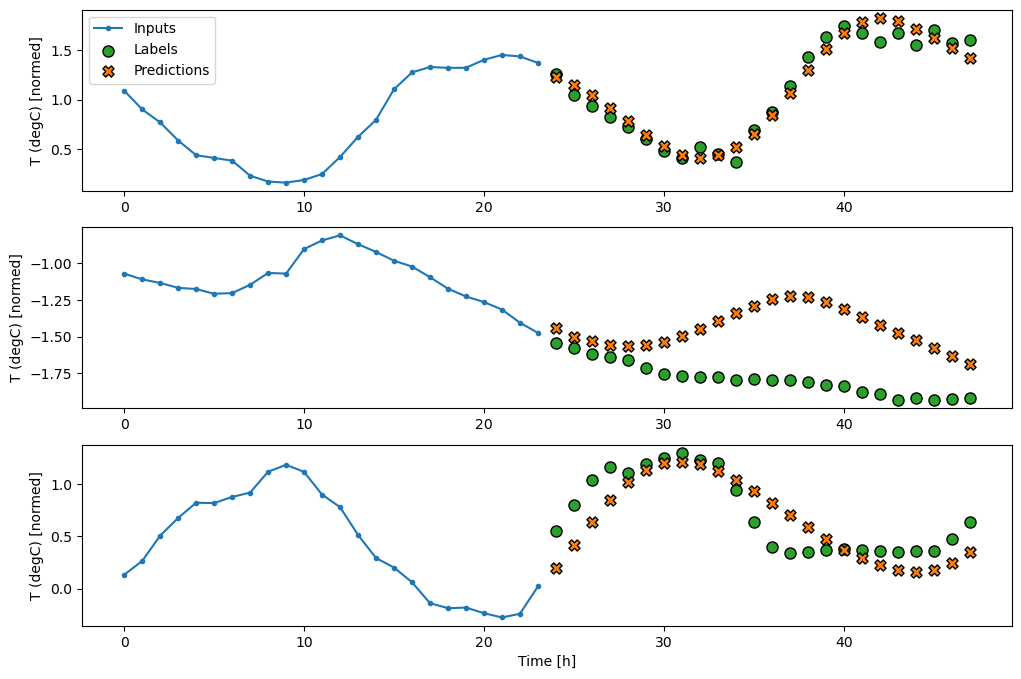

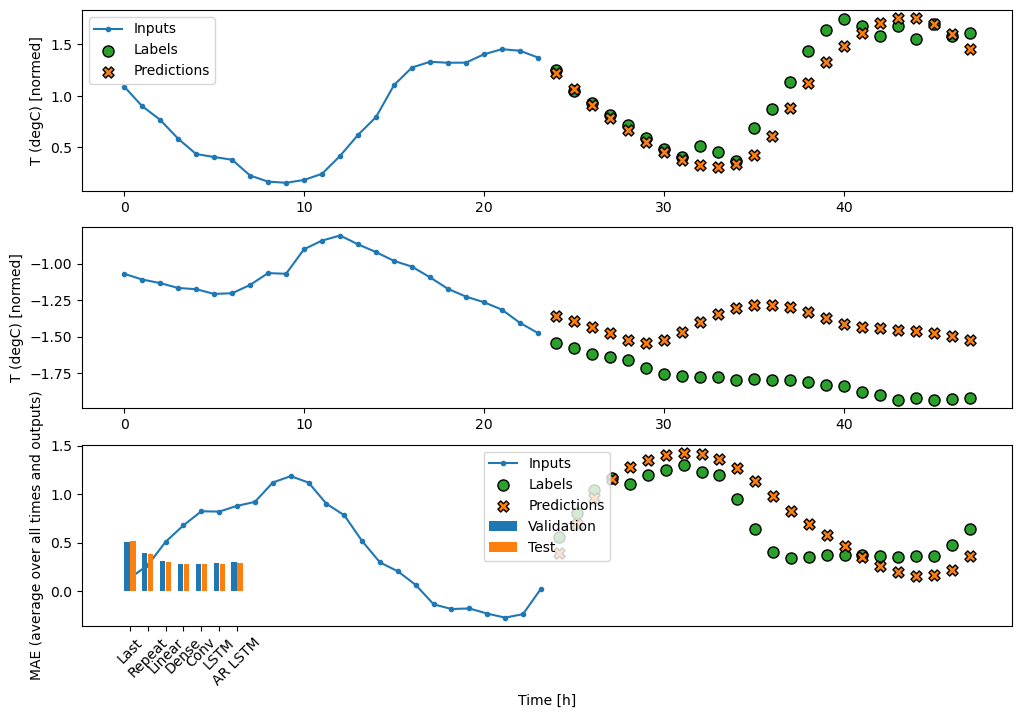

In [3]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

    # Plotting
def plot(self, model=None, plot_col="T (degC)", max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k",
                label="Labels",
                c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [h]")

    
WindowGenerator.plot =plot

    # Create tf.data.Datasets
def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

WindowGenerator.make_dataset = make_dataset

    # getting access to the tf.data.Dataset objects via WindowGenerator object
@property
def train(self):
        return self.make_dataset(self.train_df)

@property
def val(self):
        return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, "_example", None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


# Single step Single Output models

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["T (degC)"]
)

for example_inputs, example_labels in single_step_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")





baseline = Baseline(label_index=column_indices["T (degC)"])

baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0)


wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=["T (degC)"]
)

wide_window.plot(baseline)


# A linear model

linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

print("Input shape:", single_step_window.example[0].shape)
print("Output shape:", linear(single_step_window.example[0]).shape)


# packaging the training procedure in a function

MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history


history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val)
performance["Linear"] = linear.evaluate(single_step_window.test, verbose=0)


print("Input shape:", wide_window.example[0].shape)
print("Output shape:", baseline(wide_window.example[0]).shape)


wide_window.plot(linear)

# pull out the layer's weights and visualize the weight assigned to each input
plt.bar(x=range(len(train_df.columns)), height=linear.layers[0].kernel[:, 0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

# Dense Model

dense = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

history = compile_and_fit(dense, single_step_window)

val_performance["Dense"] = dense.evaluate(single_step_window.val)
performance["Dense"] = dense.evaluate(single_step_window.test, verbose=0)


# Multi Step Single Output Models

CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH, label_width=1, shift=1, label_columns=["T (degC)"]
)


conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")


multi_step_dense = tf.keras.Sequential(
    [
        # Shape: (time, features) => (time*features)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
        # Add back the time dimension.
        # Shape: (outputs) => (1, outputs)
        tf.keras.layers.Reshape([1, -1]),
    ]
)

print("Input shape:", conv_window.example[0].shape)
print("Output shape:", multi_step_dense(conv_window.example[0]).shape)

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance["Multi step dense"] = multi_step_dense.evaluate(conv_window.val)
performance["Multi step dense"] = multi_step_dense.evaluate(conv_window.test, verbose=0)

conv_window.plot(multi_step_dense)


# ConvNet

conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=(CONV_WIDTH,), activation="relu"
        ),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

print("Conv model on `conv_window`")
print("Input shape:", conv_window.example[0].shape)
print("Output shape:", conv_model(conv_window.example[0]).shape)


history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance["Conv"] = conv_model.evaluate(conv_window.val)
performance["Conv"] = conv_model.evaluate(conv_window.test, verbose=0)


print("Wide window")
print("Input shape:", wide_window.example[0].shape)
print("Labels shape:", wide_window.example[1].shape)
print("Output shape:", conv_model(wide_window.example[0]).shape)


LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=["T (degC)"],
)

wide_conv_window


print("Wide conv window")
print("Input shape:", wide_conv_window.example[0].shape)
print("Labels shape:", wide_conv_window.example[1].shape)
print("Output shape:", conv_model(wide_conv_window.example[0]).shape)


wide_conv_window.plot(conv_model)


# RNN - LSTM

lstm_model = tf.keras.models.Sequential(
    [
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1),
    ]
)


print("Input shape:", wide_window.example[0].shape)
print("Output shape:", lstm_model(wide_window.example[0]).shape)


history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance["LSTM"] = lstm_model.evaluate(wide_window.val)
performance["LSTM"] = lstm_model.evaluate(wide_window.test, verbose=0)


wide_window.plot(lstm_model)


x = np.arange(len(performance))
width = 0.3
metric_name = "mean_absolute_error"
metric_index = lstm_model.metrics_names.index("mean_absolute_error")
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel("mean_absolute_error [T (degC), normalized]")
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()


for name, value in performance.items():
    print(f"{name:12s}: {value[1]:0.4f}")


# Multi Output Models

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1,
    label_width=1,
    shift=1,
)

wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")


baseline = Baseline()
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)


val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(wide_window.val)
performance["Baseline"] = baseline.evaluate(wide_window.test, verbose=0)


dense = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=num_features),
    ]
)


history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance["Dense"] = dense.evaluate(single_step_window.val)
performance["Dense"] = dense.evaluate(single_step_window.test, verbose=0)


import time

t1 = time.perf_counter()
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential(
    [
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=num_features),
    ]
)

history = compile_and_fit(lstm_model, wide_window)
t2 = time.perf_counter()
print("time taken to run:", t2 - t1)

IPython.display.clear_output()
val_performance["LSTM"] = lstm_model.evaluate(wide_window.val)
performance["LSTM"] = lstm_model.evaluate(wide_window.test, verbose=0)

print()




t1 = time.perf_counter()
residual_lstm = ResidualWrapper(
    tf.keras.Sequential(
        [
            tf.keras.layers.LSTM(32, return_sequences=True),
            tf.keras.layers.Dense(
                num_features,
                # The predicted deltas should start small.
                # Therefore, initialize the output layer with zeros.
                kernel_initializer=tf.initializers.zeros(),
            ),
        ]
    )
)

history = compile_and_fit(residual_lstm, wide_window)
t2 = time.perf_counter()
print("time taken to run:", t2 - t1)
IPython.display.clear_output()
val_performance["Residual LSTM"] = residual_lstm.evaluate(wide_window.val)
performance["Residual LSTM"] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()


x = np.arange(len(performance))
width = 0.3

metric_name = "mean_absolute_error"
metric_index = lstm_model.metrics_names.index("mean_absolute_error")
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel("MAE (average over all outputs)")
_ = plt.legend()


for name, value in performance.items():
    print(f"{name:15s}: {value[1]:0.4f}")

# Multi steps models
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window.plot()





last_baseline = MultiStepLastBaseline()
last_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

multi_val_performance = {}
multi_performance = {}

multi_val_performance["Last"] = last_baseline.evaluate(multi_window.val)
multi_performance["Last"] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)





repeat_baseline = RepeatBaseline()
repeat_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

multi_val_performance["Repeat"] = repeat_baseline.evaluate(multi_window.val)
multi_performance["Repeat"] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


multi_linear_model = tf.keras.Sequential(
    [
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance["Linear"] = multi_linear_model.evaluate(multi_window.val)
multi_performance["Linear"] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)


multi_dense_model = tf.keras.Sequential(
    [
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(512, activation="relu"),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance["Dense"] = multi_dense_model.evaluate(multi_window.val)
multi_performance["Dense"] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)


CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential(
    [
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1,  out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance["Conv"] = multi_conv_model.evaluate(multi_window.val)
multi_performance["Conv"] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


multi_lstm_model = tf.keras.Sequential(
    [
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance["LSTM"] = multi_lstm_model.evaluate(multi_window.val)
multi_performance["LSTM"] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)





feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state


FeedBack.warmup = warmup


prediction, state = feedback_model.warmup(multi_window.example[0])


def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


FeedBack.call = call


print(
    "Output shape (batch, time, features): ",
    feedback_model(multi_window.example[0]).shape,
)


history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance["AR LSTM"] = feedback_model.evaluate(multi_window.val)
multi_performance["AR LSTM"] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)


x = np.arange(len(multi_performance))
width = 0.3

metric_name = "mean_absolute_error"
metric_index = lstm_model.metrics_names.index("mean_absolute_error")
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f"MAE (average over all times and outputs)")
_ = plt.legend()


for name, value in multi_performance.items():
    print(f"{name:8s}: {value[1]:0.4f}")